In [1]:
# import required package for data handling
import pandas as pd
import numpy as np

# import required packages for splitting data
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import required packages for evaluating models
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# import `logistic regression` model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# import the packages needed for the Decision Tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
# Loaded in the data
df = pd.read_csv('../csv_files/p1_comp2_final.csv', index_col=0)
df.head()

X1  X2  X3  X4  X5_Age_Bins  X6_Payment_Bins  X7_Payment_Bins  \
1  0.462160   2   2   1            1                2                2   
2  0.394132   2   2   2            1                1                2   
3  0.278693   2   2   2            2                2                2   
4  0.278693   2   2   1            2                2                2   
5  0.278693   1   2   1            3                1                2   

   X8_Payment_Bins  X9_Payment_Bins  X10_Payment_Bins ...   X17_abs  X17_sign  \
1                1                1                 2 ...  0.299742         0   
2                2                2                 2 ...  0.504505         1   
3                2                2                 2 ...  0.624888         1   
4                2                2                 2 ...  0.540601         1   
5                1                2                 2 ...  0.548885         1   

   X17_monthlydif  X18_binary  X19_binary  X20_binary  X21_binary  X22_binary  \
1               1           0           1           0           0           0   
2               1           0           1           1           1           0   
3               1           1           1           1           1           1   
4               1           1           1           1           1           1   
5               1           1           1           1           1           1   

   X23_binary  Y  
1           0  1  
2           1  1  
3           1  0  
4           1  0  
5           1  0  

[5 rows x 36 columns]

### Decision Tree ###

In [3]:
# Splitting up our data into variable and target data
X = df.iloc[:, :-1] # Variable
Y = df.Y # Target

In [4]:
# Split dataset into training set and test set
# 70% training and 30% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2019)

In [5]:
# import the RandomOverSampler package from imblearn 
from imblearn.over_sampling import RandomOverSampler

# define the model
ros = RandomOverSampler(random_state=2019)

# fit the training data only to the RandomOverSampler model
# this will help address the imbalanced nature of the target variable 
X_train_resample, Y_train_resample = ros.fit_resample(X_train, Y_train)

In [6]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_resample,Y_train_resample)

#Predict the response for test dataset
Y_pred = clf.predict(X_test)

In [7]:
# Model Accuracy, how often is the Decision Tree correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

# We are going to look at the classification report and also the confusion matrix for the Decision Tree  
print(metrics.classification_report(Y_test, Y_pred))
print(metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.6915555555555556
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7048
           1       0.29      0.30      0.30      1952

   micro avg       0.69      0.69      0.69      9000
   macro avg       0.55      0.55      0.55      9000
weighted avg       0.69      0.69      0.69      9000

[[5640 1408]
 [1368  584]]


### Feature Importance ###

In [8]:
# Tao's code 
# define the feature importance variable 
# use the feature importance values from the decision tree above, sort in descending order 
feature_imp = pd.Series(clf.feature_importances_,index=df.iloc[:,:-1].columns).sort_values(ascending=False)

# print the results 
feature_imp

X1                  0.109801
X12_abs             0.108466
X14_abs             0.107614
X17_abs             0.102450
X15_abs             0.097863
X13_abs             0.096822
X16_abs             0.087678
X5_Age_Bins         0.031451
X18_binary          0.029625
X3                  0.027055
X19_binary          0.021028
X20_binary          0.020342
X2                  0.017314
X4                  0.016439
X13_sign            0.014873
X14_sign            0.011302
X23_binary          0.010042
X11_Payment_Bins    0.009901
X8_Payment_Bins     0.009183
X21_binary          0.009110
X15_sign            0.008937
X22_binary          0.008428
X7_Payment_Bins     0.007309
X10_Payment_Bins    0.007011
X16_sign            0.006690
X6_Payment_Bins     0.006376
X12_sign            0.006178
X17_sign            0.005892
X9_Payment_Bins     0.004820
X12_monthlydif      0.000000
X15_monthlydif      0.000000
X13_monthlydif      0.000000
X16_monthlydif      0.000000
X17_monthlydif      0.000000
X14_monthlydif

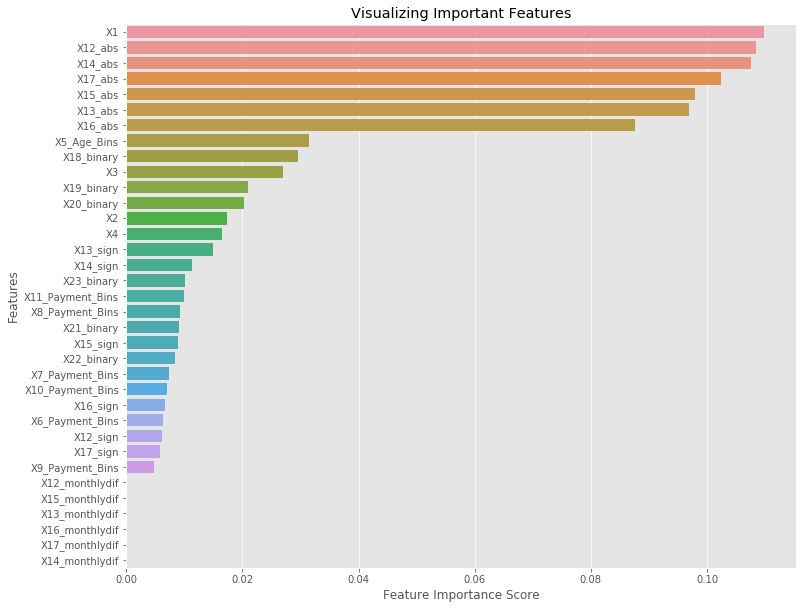

In [9]:
# Tao's code 
# visualize the feature importance values 
# not required but it helps to reinforce the differences between the features 

#import packages needed for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# define the plot style 
plt.style.use('ggplot')

# define the figure size - makes the readability of the graph better 
plt.figure(figsize=(12,10))

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

plt.show()

### Evaluate the Decision Tree ###

In [10]:
# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=2019)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf, X_train_resample, Y_train_resample, cv=kfold, scoring=scoring)

    
    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(Y_test, Y_pred)
    f1_score_lst.append(precision_recall_fscore_support(Y_test, Y_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)


print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

#result=logit_model.fit()
confusion_matrix_y = confusion_matrix(Y_test, Y_pred)


#print(result.summary())
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X_test, Y_test)))

print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

print('Confusion Matrix for Logistic Regression Classfier:')
print(confusion_matrix_y)

print('Classification Report for Logistic Regression Classfier:')
print(classification_report(Y_test, Y_pred))

F1 0.6927; AUC 0.5497 
Accuracy of classifier on test set: 0.69
10-fold cross validation average accuracy of classifier: 0.877
Confusion Matrix for Logistic Regression Classfier:
[[5640 1408]
 [1368  584]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7048
           1       0.29      0.30      0.30      1952

   micro avg       0.69      0.69      0.69      9000
   macro avg       0.55      0.55      0.55      9000
weighted avg       0.69      0.69      0.69      9000



In [11]:
"""dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())"""

'dot_data = StringIO()\nexport_graphviz(clf, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())'

### Pruning the Decision Tree ##

In [12]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train_resample,Y_train_resample)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

# We are going to look at the classification report and also the confusion matrix for our model
print(metrics.classification_report(Y_test, Y_pred))
print(metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.6915555555555556
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7048
           1       0.29      0.30      0.30      1952

   micro avg       0.69      0.69      0.69      9000
   macro avg       0.55      0.55      0.55      9000
weighted avg       0.69      0.69      0.69      9000

[[5640 1408]
 [1368  584]]


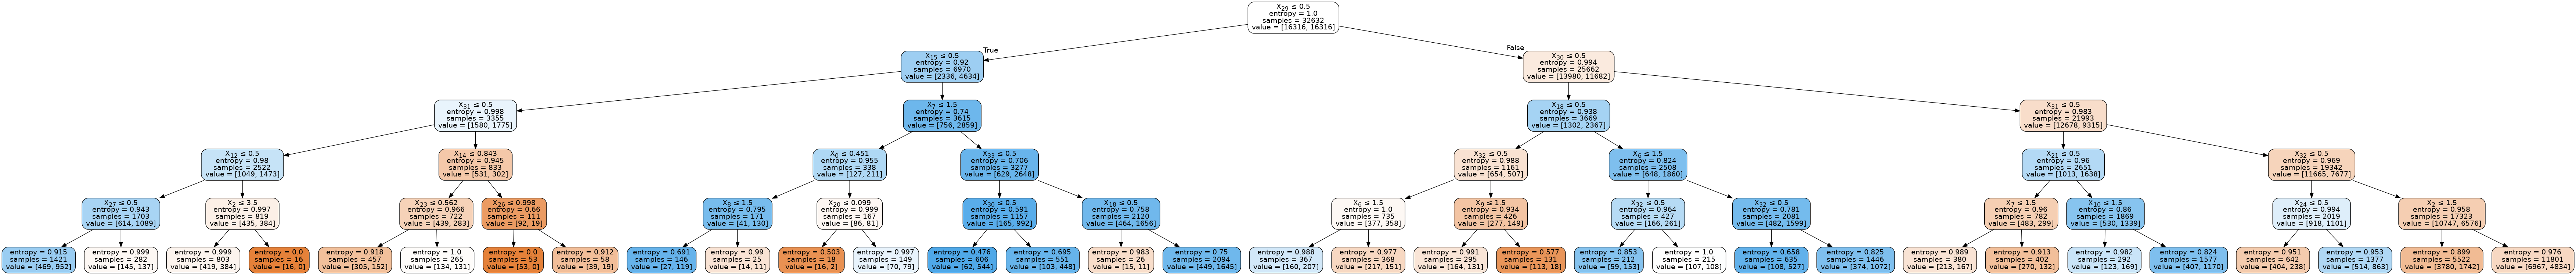

In [13]:
# visualize the pruned Decision Tree 
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Logistic Regression ###

In [14]:
X.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5_Age_Bins', 'X6_Payment_Bins',
       'X7_Payment_Bins', 'X8_Payment_Bins', 'X9_Payment_Bins',
       'X10_Payment_Bins', 'X11_Payment_Bins', 'X12_abs', 'X12_sign',
       'X12_monthlydif', 'X13_abs', 'X13_sign', 'X13_monthlydif', 'X14_abs',
       'X14_sign', 'X14_monthlydif', 'X15_abs', 'X15_sign', 'X15_monthlydif',
       'X16_abs', 'X16_sign', 'X16_monthlydif', 'X17_abs', 'X17_sign',
       'X17_monthlydif', 'X18_binary', 'X19_binary', 'X20_binary',
       'X21_binary', 'X22_binary', 'X23_binary'],
      dtype='object')

In [15]:
# initiate the logistic regression function 
logreg = LogisticRegression(solver='liblinear')

# pass the training data into the model. This training data includes all of the independent variables 
logreg = logreg.fit(X_train_resample,Y_train_resample) 

# tell the model what to predict, or in this case classify, and what variables to use to predict the dependent variable 
Y_pred=logreg.predict(X_test)

In [16]:
# calculate accuracy, precision and recall? measures of the model 
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print('Recall:',metrics.recall_score(Y_test, Y_pred))

Accuracy: 0.7112222222222222
Precision: 0.3792459873086973
Recall: 0.5204918032786885


### Evaluate the Logistic Regression ###

In [17]:
# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []

#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=2019)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(logreg, X_train_resample, Y_train_resample, cv=kfold, scoring=scoring)

    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(Y_test, Y_pred)
    f1_score_lst.append(precision_recall_fscore_support(Y_test, Y_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)


print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

#result=logit_model.fit()
confusion_matrix_y = confusion_matrix(Y_test, Y_pred)


#print(result.summary())
print('Accuracy of classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))

print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

print('Confusion Matrix for Logistic Regression Classfier:')
print(confusion_matrix_y)

print('Classification Report for Logistic Regression Classfier:')
print(classification_report(Y_test, Y_pred))

F1 0.7260; AUC 0.6423 
Accuracy of classifier on test set: 0.71
10-fold cross validation average accuracy of classifier: 0.613
Confusion Matrix for Logistic Regression Classfier:
[[5385 1663]
 [ 936 1016]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.85      0.76      0.81      7048
           1       0.38      0.52      0.44      1952

   micro avg       0.71      0.71      0.71      9000
   macro avg       0.62      0.64      0.62      9000
weighted avg       0.75      0.71      0.73      9000



In [18]:
# feature extraction 
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

for i in range(1, (df.shape[1] + 1 )):
    print(i)
    # create a base classifier used to evaluate a subset of attributes
    model = LogisticRegression()
    # create the RFE model and select 3 attributes
    rfe = RFE(model, i)
    rfe = rfe.fit(X, Y)
    # summarize the selection of the attributes
    print('Model with the best', i, 'features')
    print(dict(zip(df.columns, rfe.ranking_)))

1
Model with the best 1 features
{'X1': 18, 'X2': 15, 'X3': 33, 'X4': 16, 'X5_Age_Bins': 26, 'X6_Payment_Bins': 10, 'X7_Payment_Bins': 24, 'X8_Payment_Bins': 14, 'X9_Payment_Bins': 23, 'X10_Payment_Bins': 32, 'X11_Payment_Bins': 21, 'X12_abs': 19, 'X12_sign': 20, 'X12_monthlydif': 12, 'X13_abs': 35, 'X13_sign': 2, 'X13_monthlydif': 17, 'X14_abs': 27, 'X14_sign': 4, 'X14_monthlydif': 22, 'X15_abs': 30, 'X15_sign': 6, 'X15_monthlydif': 25, 'X16_abs': 29, 'X16_sign': 11, 'X16_monthlydif': 31, 'X17_abs': 28, 'X17_sign': 8, 'X17_monthlydif': 34, 'X18_binary': 1, 'X19_binary': 3, 'X20_binary': 5, 'X21_binary': 9, 'X22_binary': 7, 'X23_binary': 13}
2
Model with the best 2 features
{'X1': 17, 'X2': 14, 'X3': 32, 'X4': 15, 'X5_Age_Bins': 25, 'X6_Payment_Bins': 9, 'X7_Payment_Bins': 23, 'X8_Payment_Bins': 13, 'X9_Payment_Bins': 22, 'X10_Payment_Bins': 31, 'X11_Payment_Bins': 20, 'X12_abs': 18, 'X12_sign': 19, 'X12_monthlydif': 11, 'X13_abs': 34, 'X13_sign': 1, 'X13_monthlydif': 16, 'X14_abs': 26